In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import bars
import d
import signals

In [3]:
%%time

data = d.fetch("data/future/daily", "NQ.csv")
data["log_close"] = np.log(data["Close"])

adfs = signals.all_augmented_dickey_fuller_statistic(
    data["Close"],
    min_window_size=50,
    max_window_size=3000,
    window_step=10,
    stat_step=1,
    maxlag=10,
    autolag=None,
)
adfs_log = signals.all_augmented_dickey_fuller_statistic(
    data["log_close"],
    min_window_size=50,
    max_window_size=3000,
    window_step=10,
    stat_step=1,
    maxlag=10,
    autolag=None,
)

data["sadf"] = signals.supremum_augmented_dickey_fuller_statistic(stats=adfs)
data["sadf_log"] = signals.supremum_augmented_dickey_fuller_statistic(stats=adfs_log)

CPU times: total: 2h 12min 19s
Wall time: 1h 54min 30s


# Quantile ADF

<AxesSubplot:xlabel='Date'>

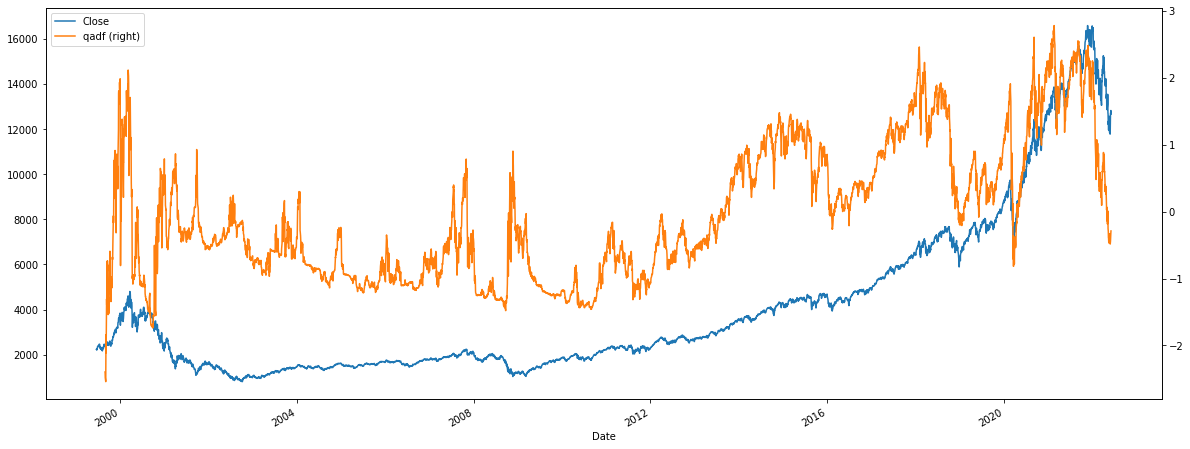

In [4]:
plt.rcParams["figure.figsize"] = (20, 8)
q = 0.85
dws = 0.20
data["qadf"], data["qadf_d"] = signals.quantile_augmented_dickey_fuller_statistic(
    q, stats=adfs, dispersion_window_size=dws
)
data[["Close", "qadf"]].interpolate(method="linear").plot(secondary_y="qadf")

<AxesSubplot:xlabel='Date'>

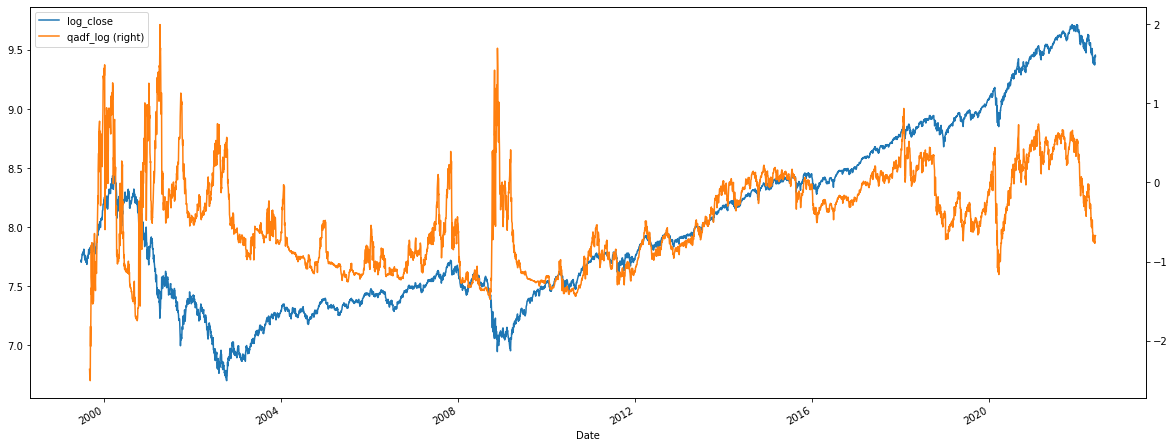

In [5]:
data["qadf_log"] = signals.quantile_augmented_dickey_fuller_statistic(
    q,
    stats=adfs_log,
)
data[["log_close", "qadf_log"]].interpolate(method="linear").plot(
    secondary_y="qadf_log"
)

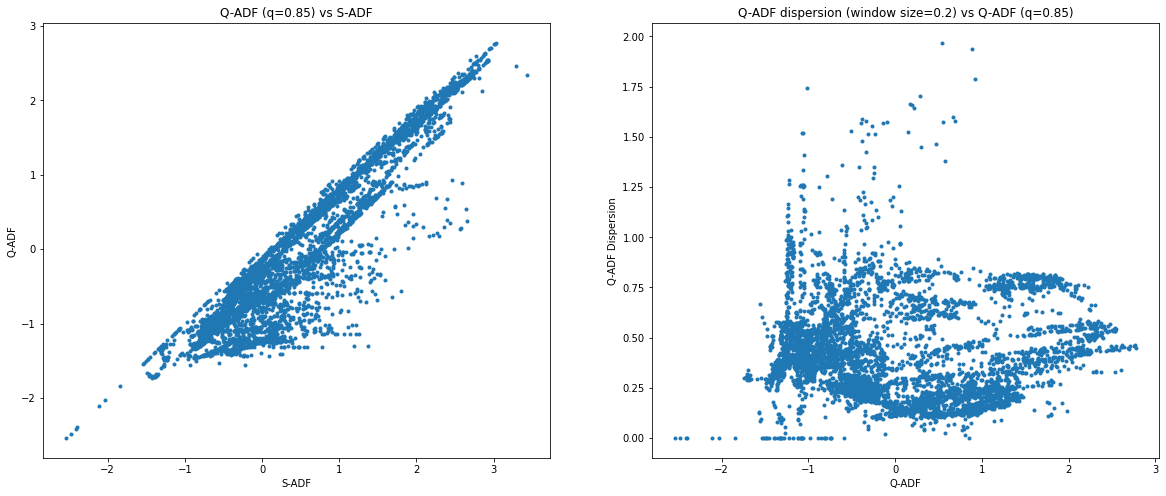

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes[0].scatter(data["sadf"], data["qadf"], marker=".")
axes[0].set_title(f"Q-ADF (q={q}) vs S-ADF")
axes[0].set_xlabel("S-ADF")
axes[0].set_ylabel("Q-ADF")
axes[1].scatter(data["qadf"], data["qadf_d"], marker=".")
axes[1].set_title(f"Q-ADF dispersion (window size={dws}) vs Q-ADF (q={q})")
axes[1].set_xlabel("Q-ADF")
axes[1].set_ylabel("Q-ADF Dispersion")
plt.show()

# Conditional ADF

<AxesSubplot:xlabel='Date'>

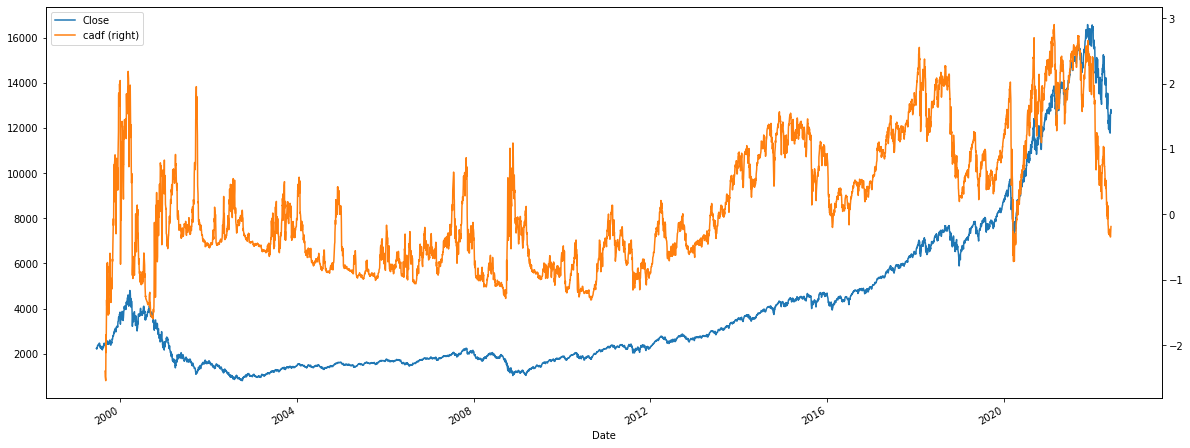

In [7]:
p = 0.85
data["cadf"], data["cadf_sd"] = signals.conditional_augmented_dickey_fuller_statistic(
    p, stats=adfs, with_stddev=True
)
data[["Close", "cadf"]].interpolate(method="linear").plot(secondary_y="cadf")

<AxesSubplot:xlabel='Date'>

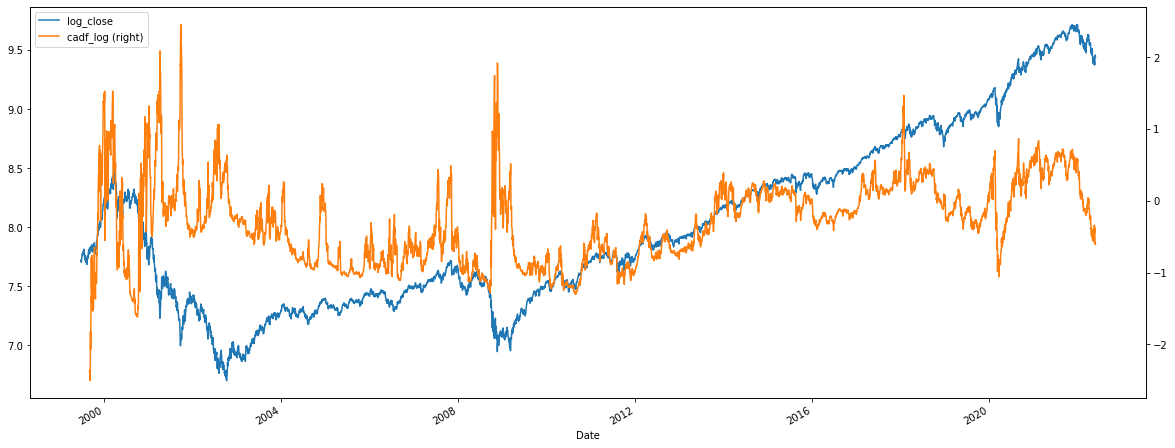

In [8]:
data["cadf_log"] = signals.conditional_augmented_dickey_fuller_statistic(
    q,
    stats=adfs_log,
)
data[["log_close", "cadf_log"]].interpolate(method="linear").plot(
    secondary_y="cadf_log"
)

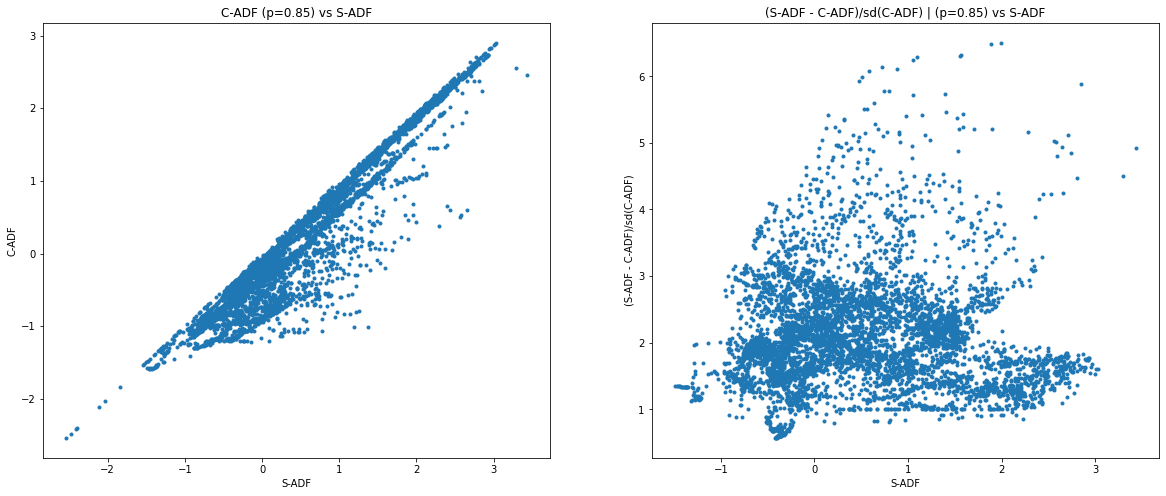

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
axes[0].scatter(data["sadf"], data["cadf"], marker=".")
axes[0].set_title(f"C-ADF (p={p}) vs S-ADF")
axes[0].set_xlabel("S-ADF")
axes[0].set_ylabel("C-ADF")

normalized_diff = data["sadf"] - data["cadf"]
normalized_diff /= data["cadf_sd"]
plt_loc = pd.notnull(normalized_diff)

axes[1].scatter(data["sadf"].loc[plt_loc], normalized_diff.loc[plt_loc], marker=".")
axes[1].set_title(f"(S-ADF - C-ADF)/sd(C-ADF) | (p={p}) vs S-ADF")
axes[1].set_xlabel("S-ADF")
axes[1].set_ylabel(f"(S-ADF - C-ADF)/sd(C-ADF)")
plt.show()